# Sentiment Analysis for Named Entities

In [1]:
from collections import defaultdict, Counter
import json
import numpy as np
import pandas as pd
from datetime import datetime as dt

In [ ]:
!nvidia-smi

Thu Mar  2 17:27:24 2023       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 525.85.12    Driver Version: 525.85.12    CUDA Version: 12.0     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla T4            Off  | 00000000:00:04.0 Off |                    0 |
| N/A   69C    P0    31W /  70W |      0MiB / 15360MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

## SA model

In [2]:
!pip install transformers

import nltk
nltk.download('punkt')

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 6.3/6.3 MB 48.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.6/7.6 MB 70.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 190.3/190.3 KB 12.9 MB/s eta 0:00:00


[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.


True

In [3]:
from nltk.tokenize import sent_tokenize
from transformers import AutoModelForSequenceClassification
from transformers import AutoTokenizer, AutoConfig
from scipy.special import softmax

In [4]:
import torch
device = "cuda:0" if torch.cuda.is_available() else "cpu"
# device = "cpu"

In [5]:
SA_MODEL = f"cardiffnlp/twitter-roberta-base-sentiment-latest"
sa_tokenizer = AutoTokenizer.from_pretrained(SA_MODEL)
sa_config = AutoConfig.from_pretrained(SA_MODEL)
sa_model = AutoModelForSequenceClassification.from_pretrained(SA_MODEL).to(device)

Some weights of the model checkpoint at cardiffnlp/twitter-roberta-base-sentiment-latest were not used when initializing RobertaForSequenceClassification: ['roberta.pooler.dense.bias', 'roberta.pooler.dense.weight']
- This IS expected if you are initializing RobertaForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing RobertaForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


In [6]:
def se_eval(text : str):
    encoded_input = sa_tokenizer(text, return_tensors='pt').to(device)
    output = sa_model(**encoded_input)
    return output[0][0].cpu()

def se_score(output : list):
    scores = output.detach().numpy()
    scores = softmax(scores)

    return {
        sa_config.id2label[i] : scores[i].item()
        for i in range(3)
    }

def sa_sentence(title: str):
    return se_score(se_eval(title))

In [7]:
sa_dict = {
    "negative": -1,
    "neutral": 0,
    "positive": 1
}

def get_sentiment(score: dict):
    return max(score, key=score.get)

def the_most(key: str, scores: list):
    st = max(enumerate(scores), key=lambda sa: sa[1][key])
    return {
        "sentence_number": st[0], 
        f"{key} score": st[1][key]
    }

## NER model

In [8]:
!pip install flair

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 401.9/401.9 KB 1.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.2/1.2 MB 43.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 788.5/788.5 KB 36.3 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 19.7/19.7 MB 58.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 981.5/981.5 KB 34.0 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.6/1.6 MB 66.1 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 53.1/53.1 KB 5.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 200.5/200.5 KB 20.2 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
  Created wheel for mpld3: filename=mpld3-0.3-py3-non

In [9]:
import flair
from flair.models import SequenceTagger
from flair.tokenization import SegtokSentenceSplitter
from flair.data import Sentence

In [ ]:
torch.cuda.is_available()

True

In [ ]:
flair.device = torch.device("cuda:0")

In [10]:
ner_splitter = SegtokSentenceSplitter()
# ner_tagger = SequenceTagger.load('ner')
ner_tagger = SequenceTagger.load('ner-fast')

/usr/local/lib/python3.8/dist-packages/huggingface_hub/file_download.py:629: FutureWarning: `cached_download` is the legacy way to download files from the HF hub, please consider upgrading to `hf_hub_download`
  warnings.warn(


2023-03-03 09:58:12,497 loading file /root/.flair/models/ner-english-fast/4c58e7191ff952c030b82db25b3694b58800b0e722ff15427f527e1631ed6142.e13c7c4664ffe2bbfa8f1f5375bd0dced866b8c1dd7ff89a6d705518abf0a611
2023-03-03 09:58:14,164 SequenceTagger predicts: Dictionary with 20 tags: <unk>, O, S-ORG, S-MISC, B-PER, E-PER, S-LOC, B-ORG, E-ORG, I-PER, S-PER, B-MISC, I-MISC, E-MISC, I-ORG, B-LOC, E-LOC, I-LOC, <START>, <STOP>


In [11]:
def split_news(news: dict):
    splitted = ner_splitter.split(news["content"])
    splitted.append(Sentence(news["title"]))
    if isinstance(news["description"], str):
        splitted.extend(
            ner_splitter.split(news["description"])
        )
    return splitted

## Data

In [12]:
import random
from pprint import pprint
import json
from google.colab import drive

In [13]:
drive.mount('/content/up_nlp/', force_remount=True)

Mounted at /content/up_nlp/


In [14]:
with open("/content/up_nlp/MyDrive/up_nlp/data.json", "r") as data_file:
    data = json.load(data_file)

for news in data:
    if "$date" in news["date"].keys():
        news["date"] = dt.fromtimestamp(int(list(news["date"]["$date"].values())[0]) / 1e3)
    else:
        news["date"] = pd.NaT

len(data)

42635

In [ ]:
# FULL_TEXT_SA_N_SAMPLES = 1000

In [ ]:
# news = sorted(
#     random.sample(data, FULL_TEXT_SA_N_SAMPLES),
#     key=lambda news: news["index"]
# )

# [_["index"] for _ in news];

In [ ]:
sample = random.sample(data, 1)[0]

# sample = data[1984]

# sample = news[0]

## Evaluating

In [15]:
from tqdm import tqdm

In [ ]:
stats = {
    "SAMPLES": [_["index"] for _ in data],
    "PER":  defaultdict(list),
    "LOC":  defaultdict(list),
    "ORG":  defaultdict(list),
    "MISC": defaultdict(list)
}

In [ ]:
def sa4ner_eval(stats: dict, news: dict):
    splitted = split_news(news)

    sa_stats = [sa_sentence(sentence.text) for sentence in splitted]
    ner_tagger.predict(splitted)

    sample_stats = {
        "PER":  defaultdict(list),
        "LOC":  defaultdict(list),
        "ORG":  defaultdict(list),
        "MISC": defaultdict(list)
    }     

    # ---
    # `sa`-statistic is added for analysis on full dataset
    # title
    title_sa = sa_dict[get_sentiment(sa_stats[-1])]
    for entity in splitted[len(splitted)-1].get_spans("ner"):
        # title is the `minus 1-st` sentence in the list of sentences
        sample_stats[entity.tag][entity.text].append(
            (-1, title_sa)
        )
    # content and description
    for sentence_i in range(len(splitted)-1):
        sentence_sa = sa_dict[get_sentiment(sa_stats[sentence_i])]
        for entity in splitted[sentence_i].get_spans("ner"):
            sample_stats[entity.tag][entity.text].append(
                (sentence_i, sentence_sa)
            )
    # ---

    # write stats for full dataset
    if not news["index"] in stats["SAMPLES"]:
        stats["SAMPLES"].append(news["index"])
        for key in sample_stats.keys():
            for entity in sample_stats[key].keys():
                stats[key][entity].append((news["index"], sample_stats[key][entity]))
    
    # but return stats for the sample
    return {
        "INDX": news["index"],
        "SENTENCES": splitted,
        "SA": sa_stats,
        "NER": sample_stats
    }

In [ ]:
stats = {
    "SAMPLES": [],
    "PER":  defaultdict(list),
    "LOC":  defaultdict(list),
    "ORG":  defaultdict(list),
    "MISC": defaultdict(list)
}

In [ ]:
full_stats = []
failed = []
for news_id in tqdm(range(FULL_TEXT_SA_N_SAMPLES)):
    try:
        full_stats.append(
            sa4ner_eval(
                stats,
                news[news_id]
            )
        )
    except:
        failed.append(news[news_id]["index"])
print(f"Failed samples: {failed}")

100%|██████████| 1000/1000 [22:50<00:00,  1.37s/it]

Failed samoles: [2369, 3060, 3759, 4604, 16036, 17206, 18955, 19050, 19112, 19316, 19746, 20060, 20632, 21769, 21845, 22183, 24702, 25170, 25415, 27048, 28795, 28823, 30066, 32245, 40476, 40723]


In [ ]:
# with open("/content/up_nlp/MyDrive/up_nlp/sa4ner__full_stats.json", "w") as file:
#     file.write(json.dumps(full_stats))

with open("/content/up_nlp/MyDrive/up_nlp/sa4ner__stats.json", "w") as file:
    file.write(json.dumps(stats))

### Full

In [16]:
stats = {
    "SAMPLES": [],
    "PER":  defaultdict(list),
    "LOC":  defaultdict(list),
    "ORG":  defaultdict(list),
    "MISC": defaultdict(list)
}
failed = []

In [17]:
def sa4ner_eval_dataset(stats: dict, news: dict):
    if not news["index"] in stats["SAMPLES"]:
        splitted = split_news(news)

        sa_stats = [sa_sentence(sentence.text) for sentence in splitted]
        ner_tagger.predict(splitted)

        sample_stats = {
            "PER":  defaultdict(list),
            "LOC":  defaultdict(list),
            "ORG":  defaultdict(list),
            "MISC": defaultdict(list)
        }     

        # ---
        # `sa`-statistic is added for analysis on full dataset
        # title
        title_sa = sa_dict[get_sentiment(sa_stats[-1])]
        for entity in splitted[len(splitted)-1].get_spans("ner"):
            # title is the `minus 1-st` sentence in the list of sentences
            sample_stats[entity.tag][entity.text].append(
                (-1, title_sa)
            )
        # content and description
        for sentence_i in range(len(splitted)-1):
            sentence_sa = sa_dict[get_sentiment(sa_stats[sentence_i])]
            for entity in splitted[sentence_i].get_spans("ner"):
                sample_stats[entity.tag][entity.text].append(
                    (sentence_i, sentence_sa)
                )
        # ---

        # write stats for full dataset
        stats["SAMPLES"].append(news["index"])
        for key in sample_stats.keys():
            for entity in sample_stats[key].keys():
                stats[key][entity].append((news["index"], sample_stats[key][entity]))
    else:
        pass

In [ ]:
for news_id in tqdm(range(0, 5000)):
    try:
        sa4ner_eval_dataset(stats, data[news_id])
        pass
    except:
        failed.append(data[news_id]["index"])
print(f"Failed samples: {failed}")

  0%|          | 13/5000 [02:24<15:04:13, 10.88s/it]

In [ ]:
len(stats["SAMPLES"])

1

In [ ]:
sa4ner_eval_dataset(stats, data[39000])

In [ ]:
# with open("/content/up_nlp/MyDrive/up_nlp/sa4ner__full_stats.json", "w") as file:
#     file.write(json.dumps(full_stats))

with open("/content/up_nlp/MyDrive/up_nlp/sa4ner__stats.json", "w") as file:
    file.write(json.dumps(stats))

## Analysis

In [ ]:
from itertools import chain
import matplotlib.pyplot as plt

In [ ]:
sample

{'index': 26314,
 'source': 'CNN',
 'date': datetime.datetime(2016, 7, 13, 0, 0),
 'title': 'The Open 2016: Prestwick claims major birthplace - CNN',
 'category': 'sport',
 'description': 'St. Andrews may be the home of golf, but Prestwick is birthplace of the Open.',
 'content': 'Story highlightsRoyal Troon to host 145th British Open The Open began at Prestwick in 1860Prestwick has held The Open 24 timesPrestwick, Scotland (CNN)St. Andrews may be the undisputed home of golf, but it\'s not the birthplace of the sport\'s oldest major championship.That distinct honor belongs to the quiet town of Prestwick, on Scotland\'s rugged, wind-battered west coast.It was here in 1960 that Elvis Presley stepped onto UK soil for the only time in his life as the U.S. army plane he was traveling on refueled at the town\'s airport.Follow @cnnsport\n\n But Prestwick\'s sporting claim to fame goes back a century before "The King" touched down.Read MoreThe first 12 editions of the Open Championship were st

In [ ]:
sample_stats = sa4ner_eval(
    stats,
    sample
)

In [ ]:
sample_stats

{'INDX': 26314,
 'SENTENCES': [Sentence: "Story highlightsRoyal Troon to host 145th British Open The Open began at Prestwick in 1860Prestwick has held The Open 24 timesPrestwick , Scotland ( CNN ) St. Andrews may be the undisputed home of golf , but it 's not the birthplace of the sport 's oldest major championship.That distinct honor belongs to the quiet town of Prestwick , on Scotland 's rugged , wind-battered west coast.It was here in 1960 that Elvis Presley stepped onto UK soil for the only time in his life as the U.S. army plane he was traveling on refueled at the town 's airport.Follow @ cnnsport" → ["Story highlightsRoyal Troon"/MISC, "145th British Open The Open"/MISC, "Prestwick"/LOC, "The Open"/MISC, "timesPrestwick"/LOC, "Scotland"/LOC, "CNN"/ORG, "St. Andrews"/LOC, "Prestwick"/LOC, "Scotland"/LOC, "Elvis Presley"/PER, "UK"/LOC, "U.S."/LOC],
  Sentence: "But Prestwick 's sporting claim to fame goes back a century before " The King " touched down.Read MoreThe first 12 edition

### Most positive/negative sentence

In [ ]:
most_positive = the_most("positive", sample_stats["SA"][:-1])
print(sample_stats["SENTENCES"][most_positive["sentence_number"]]) 
print(most_positive)

Sentence: "And there is sure to be many a golfing fan making the short pilgrimage to the tournament 's first home.Designed by the legendary golfer , Old Tom Morris , 12 of Prestwick 's original greens are still in use , ensuring modern players can walk in the footsteps of many of the game 's giants.The railway line , which runs alongside the first hole , is an iconic feature of the course as are the giant bunkers and sand dunes that also remain from the glory days of Open Championships.The first hole at Prestwick Golf Club is overlooked by an active railway.According to Prestwick head professional David Fleming , visitors from around the globe are a common sight on the course. " Anybody who 's got any knowledge of golf will want to come and walk footsteps on this bit of land ," Fleming says. " We 're very fortunate from that point of view. " Fleming describes the Prestwick course as a " museum " but with winds regularly reaching 25 mph it remains a test , even for the best golfers. " I

In [ ]:
most_negative = the_most("negative", sample_stats["SA"][:-1])
print(sample_stats["SENTENCES"][most_negative["sentence_number"]]) 
print(most_negative)

Sentence: "" Without Prestwick I do n't think there would be an Open in the same way that it is now . "" → ["Prestwick"/ORG, "Open"/MISC]
{'sentence_number': 2, 'negative score': 0.4611540734767914}


### Full

In [ ]:
with open("/content/up_nlp/MyDrive/up_nlp/sa4ner__stats.json", "r") as file:
    stats = json.load(file)

for key in ["PER", "LOC", "ORG", "MISC"]:
    stats[key] = defaultdict(list, stats[key])

In [ ]:
{key: len(stats[key]) for key in ["PER", "LOC", "ORG", "MISC"]}

{'PER': 9130, 'LOC': 2895, 'ORG': 5126, 'MISC': 4368}

In [ ]:
top = {
    "PER": defaultdict(list, sorted(stats["PER"].items(), key=lambda ent: len(ent[1]), reverse=True)[:10]),
    "ORG": defaultdict(list, sorted((_ for _ in stats["ORG"].items() if not _[0].startswith("CNN")), key=lambda ent: len(ent[1]), reverse=True)[:10]),
    "LOC": defaultdict(list, sorted(stats["LOC"].items(), key=lambda ent: len(ent[1]), reverse=True)[:10]),
}

{key: len(top[key]) for key in ["PER", "LOC", "ORG"]}

{'PER': 10, 'LOC': 10, 'ORG': 10}

In [ ]:
# very famous persons
vfps = list(top["PER"].keys()) # no Obama(
vfps

['Donald Trump',
 'Trump',
 'Vladimir Putin',
 'Putin',
 'Joe Biden',
 'Biden',
 'God',
 'Novak Djokovic',
 'Roger Federer',
 'Boris Johnson']

In [ ]:
[vfps[0:1]]

[['Donald Trump']]

In [ ]:
top["PER"][vfps[0]]

[[4562, [[3, 0]]],
 [4894, [[4, -1]]],
 [4898, [[26, -1]]],
 [5075, [[39, 0]]],
 [5378, [[2, -1], [66, 1], [80, 0], [168, 0], [169, 0]]],
 [5450, [[18, -1]]],
 [5488, [[3, -1], [5, -1], [9, 0]]],
 [5901, [[17, 0]]],
 [6418, [[0, 0], [10, 0]]],
 [6508, [[20, -1], [25, -1], [30, 0], [78, -1]]],
 [6673, [[7, -1], [16, 0], [46, -1]]],
 [6746, [[14, 0]]],
 [6766, [[5, 1]]],
 [6824, [[1, 0], [36, 0]]],
 [6828, [[36, -1]]],
 [6836, [[4, 0], [35, 0]]],
 [6867, [[0, 0], [3, -1]]],
 [7728, [[17, 0]]],
 [8075, [[5, 0]]],
 [8209, [[3, 0]]],
 [8247, [[8, -1]]],
 [8264, [[62, -1]]],
 [8456, [[5, 0]]],
 [8709, [[72, 1]]],
 [9237, [[6, 0]]],
 [10886, [[9, 0]]],
 [11162, [[2, 0]]],
 [11394, [[-1, 0], [0, 0]]],
 [11406, [[1, 0]]],
 [11466, [[-1, 0], [0, 0]]],
 [11544, [[-1, 0], [0, 0], [44, -1]]],
 [11644, [[30, 0]]],
 [12344, [[0, 0]]],
 [12841, [[-1, 0], [30, 0], [34, 0], [50, 0]]],
 [13129, [[42, 0]]],
 [13219, [[14, 0]]],
 [13780, [[5, 0]]],
 [13806, [[25, 0]]],
 [13856, [[-1, 0], [1, 0]]],
 [14075,

In [ ]:
def vfp_stats(vfp, news):
    st = Counter(_[1] for _ in news[1])
    return {
        "person": vfp,
        "date": data[news[0]]["date"],
        "index": data[news[0]]["index"],
        "all": len(news[1]),
        "positive": st[1],
        "neutral": st[0],
        "negative": st[-1]
    }

In [ ]:
vfps_df = pd.DataFrame(list(chain.from_iterable([
    [
        vfp_stats(vfp, news)
        for news in top["PER"][vfp]
    ]
    for vfp in vfps
])))

vfps_df

,person,date,index,all,positive,neutral,negative
0,Donald Trump,2016-11-26,4562,1,0,1,0
1,Donald Trump,2022-03-15,4894,1,0,0,1
2,Donald Trump,2022-02-16,4898,1,0,0,1
3,Donald Trump,2020-10-28,5075,1,0,1,0
4,Donald Trump,2016-10-21,5378,5,1,3,1
...,...,...,...,...,...,...,...
411,Boris Johnson,2020-11-07,38627,1,0,1,0
412,Boris Johnson,2021-01-05,39088,1,0,1,0
413,Boris Johnson,2021-03-31,39320,2,0,1,1
414,Boris Johnson,2021-03-22,39394,2,0,0,2


In [ ]:
vfp_st = (
    vfps_df[vfps_df.person == vfps[0]]
        .groupby(vfps_df[vfps_df.person == vfps[0]].date.dt.year)
        .sum()
)

vfp_st

,index,all,positive,neutral,negative
date,,,,,
2012,41906,2,0,2,0
2016,66694,16,1,13,2
2017,142017,11,2,6,3
2018,278394,20,0,16,4
2019,178032,10,0,9,1
2020,132710,18,2,11,5
2021,148301,12,0,8,4
2022,115537,18,0,11,7


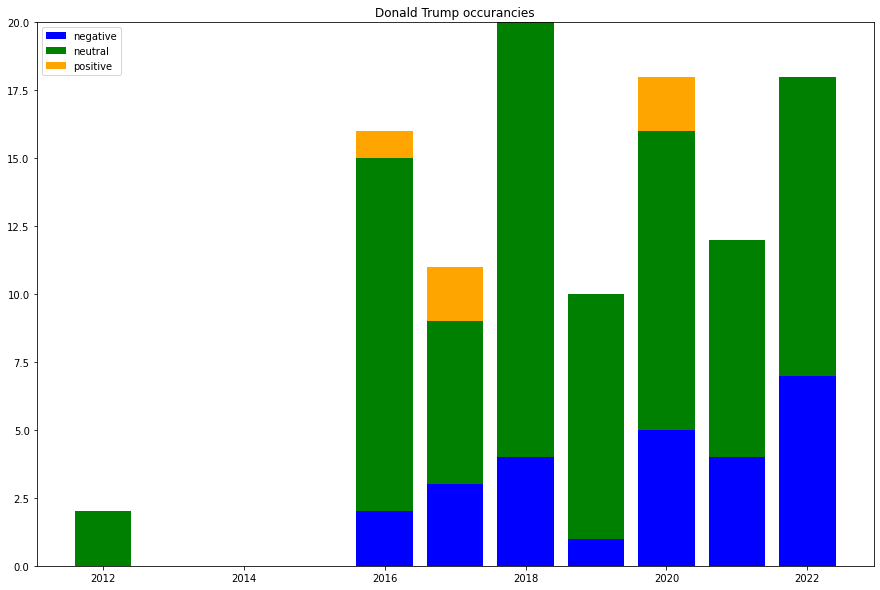

In [ ]:
fig, ax = plt.subplots(figsize=(15, 10))
bottom = np.zeros(len(vfp_st))

p = ax.bar(vfp_st.index, vfp_st.negative, label="negative", bottom=bottom, color="blue")
bottom += vfp_st.negative

p = ax.bar(vfp_st.index, vfp_st.neutral, label="neutral", bottom=bottom, color="green")
bottom += vfp_st.neutral

p = ax.bar(vfp_st.index, vfp_st.positive, label="positive", bottom=bottom, color="orange")
bottom += vfp_st.positive

plt.title(f"{vfps[0]} occurancies")
ax.legend(loc="upper left")
plt.show()

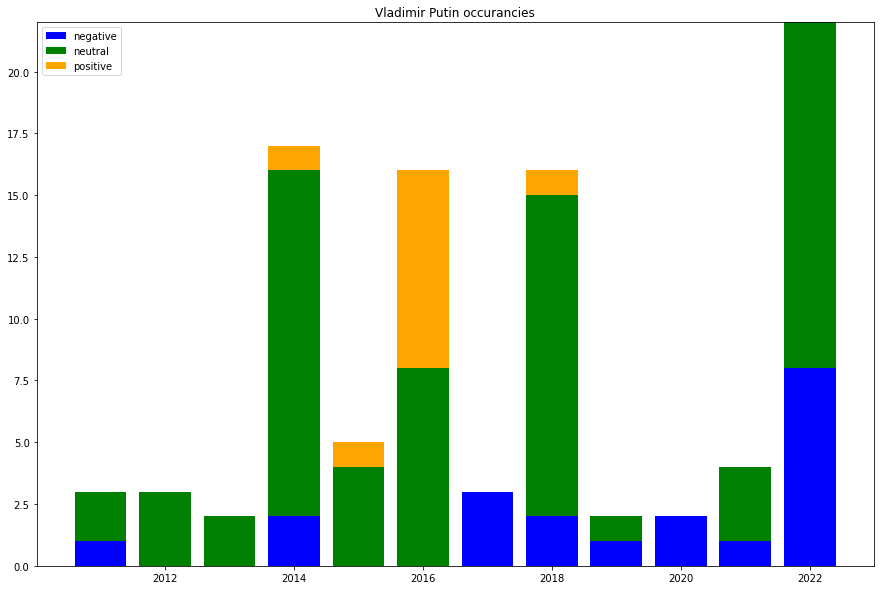

In [ ]:
vfp_id = 2

vfp_st = (
    vfps_df[vfps_df.person == vfps[vfp_id]]
        .groupby(vfps_df[vfps_df.person == vfps[vfp_id]].date.dt.year)
        .sum()
)

fig, ax = plt.subplots(figsize=(15, 10))
bottom = np.zeros(len(vfp_st))

p = ax.bar(vfp_st.index, vfp_st.negative, label="negative", bottom=bottom, color="blue")
bottom += vfp_st.negative

p = ax.bar(vfp_st.index, vfp_st.neutral, label="neutral", bottom=bottom, color="green")
bottom += vfp_st.neutral

p = ax.bar(vfp_st.index, vfp_st.positive, label="positive", bottom=bottom, color="orange")
bottom += vfp_st.positive

plt.title(f"{vfps[vfp_id]} occurancies")
ax.legend(loc="upper left")
plt.show()